To Do:  
- Replace lat in table by intensity weighted lat  

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from src import tracks
%matplotlib inline

C:\Users\jsprd\Anaconda3\envs\py313\Lib\site-packages\pyproj\network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
params = {
    'font.size': 10,
    'legend.fontsize': 'small',
    'figure.figsize': (15, 5),
    'axes.labelsize': 'medium',
    'axes.titlesize':'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'hatch.linewidth': 0.3,
}
plt.rcParams.update(params)

In [3]:
Zsig = 1.96 # max. Z-score for hatching (1.645 for 90%, 1.96 for 95% CI)

#plt.rcdefaults()
#datapath = "../../tracker/data"
datapath = Path("../../tracker/jobs/Tracking_TC_RV")
ext = ""  # ["",".infext2",etc...]
#datapath = "/home/jasperdj/files_rene/"
figpath = Path("../figures")

In [4]:
ds = tracks.load_tracks('../../tracker/jobs/Tracking_TC_RV/', ext='')

REF.001: 5.000 years, 475 tracks
REF.002: 5.000 years, 484 tracks
REF.003: 5.000 years, 496 tracks
REF.004: 5.000 years, 500 tracks
REF.005: 5.000 years, 523 tracks
REF.006: 5.000 years, 462 tracks
RCP.001: 5.000 years, 445 tracks
RCP.002: 5.000 years, 437 tracks
RCP.003: 5.000 years, 459 tracks
RCP.004: 5.000 years, 464 tracks
RCP.005: 5.000 years, 455 tracks
RCP.006: 5.000 years, 473 tracks
SAI.001: 5.000 years, 425 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 412 tracks
SAI.004: 5.000 years, 430 tracks
SAI.005: 5.000 years, 406 tracks
SAI.006: 5.000 years, 421 tracks


In [10]:
num = {
    'ref':np.array([475,484,496,500,523,462]),
    'cnt':np.array([445,437,459,464,455,473]),
    'sai':np.array([425,430,412,430,406,421])
}
print(f"mean 1-6 = ref: {num['ref'].mean()/5:.1f}, cnt: {num['cnt'].mean()/5:.1f} ({(num['cnt'].mean()-num['ref'].mean())/num['ref'].mean()*100:+.1f}%), sai: {num['sai'].mean()/5:.1f} ({(num['sai'].mean()-num['ref'].mean())/num['ref'].mean()*100:+.1f}%)")
print(f"mean 1-5 = ref: {num['ref'][:5].mean()/5:.1f}, cnt: {num['cnt'][:5].mean()/5:.1f} ({(num['cnt'][:5].mean()-num['ref'][:5].mean())/num['ref'][:5].mean()*100:+.1f}%), sai: {num['sai'][:5].mean()/5:.1f} ({(num['sai'][:5].mean()-num['ref'][:5].mean())/num['ref'][:5].mean()*100:+.1f}%)")

mean 1-6 = ref: 98.0, cnt: 91.1 (-7.0%), sai: 84.1 (-14.1%)
mean 1-5 = ref: 99.1, cnt: 90.4 (-8.8%), sai: 84.1 (-15.1%)


In [5]:
# check for gaps in track (i.e. last numeric value should be next to first null value)
for tid in ds['Reference'].id:
    lons = ds['Reference'].lon.sel(id=tid).data
    if not (np.searchsorted(np.isnan(lons), False, side='right') == np.searchsorted(np.isnan(lons), True, side='left')):
        print(f"WARNING: gaps in track {id=}\n{lons=}")

In [6]:
ds_topo = xr.open_dataset("../data/USGS_gtopo30_0.23x0.31_remap_c061107.nc")  # topography file CESM

In [7]:
# SSTdata =  xr.open_dataset("../data/SST.nc")

# # add cyclical point
# SSTdata = xr.concat((SSTdata, SSTdata.isel(nlon=0)), dim='nlon') 

# # invalid points
# mask = (SSTdata.ULONG==-1) & (SSTdata.ULAT==-1)

# # remove sudden 360 deg jumps in longitude
# SSTdata.ULONG.data += 360 * ((SSTdata.ULONG<0) & (SSTdata.nlon>2500) & ~mask)
# assert (abs(SSTdata.ULONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"

# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=220))
# SSTdata.SST.sel(exp='ref',month=11).plot.contour(ax=ax, levels=[25], transform=ccrs.PlateCarree())
# ax.coastlines()

#SSTdata.isel(month=0,exp=0).SST.plot()

In [8]:
# # track density
# xbins=np.arange(0, 361, 5)
# ybins=np.arange(-90, 91, 5)
# hists = {exp: tracks.track_density(ds[exp], xbins=xbins, ybins=ybins) for exp in ds}
# hists = {exp: hist.stack(x=['ens','year']) for exp,hist in hists.items()}
# stderr = {exp: hists[exp].hcount.std('x', ddof=1)/np.sqrt(hists[exp].x.size) for exp in hists}

# # split tracks in segments for colouring
# vmin, vmax, Nv = 910, 990, 17
# segments = {exp: tracks.track_segments(ds[exp], np.linspace(vmin,vmax,Nv), central_longitude=200) for exp in ds}

In [9]:
%%time

# track density with standard error
xbins=np.arange(0, 361, 5)
ybins=np.arange(-90, 91, 5)

hists = {exp: (tracks.track_density(ds[exp], xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds}
stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1].mean('x') - hists[exp2].mean('x')
    histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    hists[exp] = hists[exp].where(histsum!=0)
    stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds:
    hists[exp] = hists[exp].mean('x', keep_attrs=True)
    hists[exp] = hists[exp].where(hists[exp]!=0)
    
# split tracks in segments for colouring
vmin, vmax, Nv = 910, 990, 17
segments = {exp: tracks.track_segments(ds[exp], np.linspace(vmin,vmax,Nv), central_longitude=200) for exp in ds}

CPU times: total: 34.1 s
Wall time: 35.4 s


saving ../figures/fig01_tracks.pdf...
CPU times: total: 26.4 s
Wall time: 26.7 s


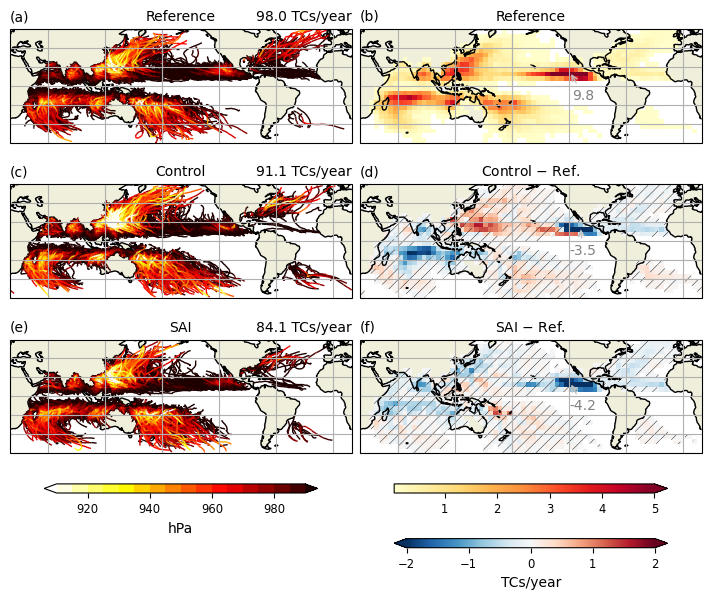

In [11]:
%%time

figname = "fig01_tracks.pdf"
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Reference',
    '(c)': 'Control',
    '(d)': 'Control $-$ Ref.',
    '(e)': 'SAI',
    '(f)': 'SAI $-$ Ref.'
}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(3,2, sharex=True, sharey=True, layout='constrained', 
                        figsize=(7,6), # (width, height (in))
                        subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)},
                       )
                        # gridspec_kw={'hspace':0.12})

############ tracks ################
cmap = plt.get_cmap('hot_r')
for exp, ax in zip(ds, axs[:,0]):
    for clevid, segs in list(segments[exp].items())[:]: ############### remove [:1] to plot all tracks #################
        color = cmap((clevid-0.5)/(Nv))
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(central_longitude=200), capstyle='butt'), autolim=False)
    ax.set_title(f"{ds[exp].id.size/ds[exp].num_days*365:.1f} TCs/year", loc='right')

# colormap tracks
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs[:,0], extend='both', **cbkwargs)
cb.ax.set_xlabel('hPa')

############ track density #############

ax = axs[0,1] # ref. track density
cfdata = hists['Reference']
cf_ref = cfdata.plot(ax=ax, vmax=5, cmap='YlOrRd', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='max')

ax = axs[1,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, vmin=-2, vmax=2, cmap='RdBu_r', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='min')
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

ax = axs[2,1] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, vmin=-2, vmax=2, cmap='RdBu_r', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='min')
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,1], extend='max', **cbkwargs)
    
for ax,(ref,title) in zip(axs.flat, titles.items()):
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    ax.gridlines()
    ax.set_title(title)
    ax.set_title(ref, loc='left')
    ax.set_extent((-180,180,-60,60), crs=ccrs.PlateCarree())

tracks.savefig(fig, figname, bbox_inches='tight', transparent=True)

In [10]:
# def add_cyclic(da):
#     """convenience wrapper for cartopy.util.add_cyclic for xarray"""
#     lats, lons = xr.broadcast(da.lat, da.lon)
#     cdata, clons, clats = cutil.add_cyclic(da, lons, lats)
#     ccoords = {c: da[c] for c in da.coords}
#     ccoords['lon'] = (lons.dims, clons, lons.attrs)
#     ccoords['lat'] = (lats.dims, clats, lats.attrs)
#     return xr.DataArray(cdata, ccoords, da.dims)


# # ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
# lons = np.linspace(0,359,360)
# lats = np.linspace(-90,90,181)
# da = (np.cos(lats/45*np.pi) + 1.5)[:,None] * (np.cos(lons/180*np.pi))[None,:]
# da = xr.DataArray(da, [('lat',lats),('lon',lons)])
# da = add_cyclic(da)


# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
# da.plot.contourf(ax= ax, transform=ccrs.PlateCarree())
# cs = da.plot.contour(ax=ax, levels=[-2,-1,1,2], transform=ccrs.PlateCarree())

# import json

# with open('segments.txt','w') as f:
#     allsegs_list = {str(c): [list(s) for s in segs] for c,segs in zip(cs.levels,allsegs)}
#     json.dump(allsegs_list, f)

# with open('segments.txt','r') as f:
#     allsegs_read = json.load(f)

In [11]:
# allsegs_read == allsegs_list


saving ../figures/fig02.pdf...


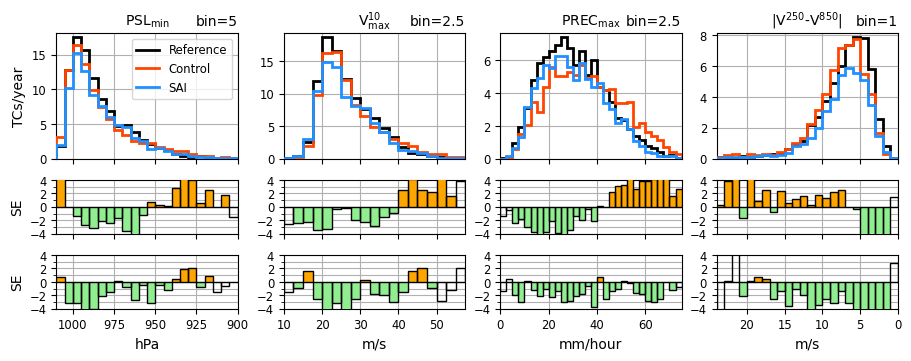

In [12]:
hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
#     'PSL': {'bins': np.arange(900,1015,2.5), 'title': r'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSL': {'bins': np.arange(900,1015,5), 'title': r'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': r'PSL$_{\mathrm{monthly}}$', 'rev':True},
#     'U10': {'bins': np.arange(10,60,1), 'title': r'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'U10': {'bins': np.arange(10,60,2.5), 'title': r'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': r'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(4e-4,4e-3,1e-4), 'title': r'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': r'|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,2.5), 'title': r'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': r'$\Delta$T$^{850}$', 'rev':False},
}

yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
# method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['PSL','U10','PRECT','Vshear'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)

fig,axs = plt.subplots(3,4, height_ratios=(7,3,3), figsize=(9,3.5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))

# ds_max = {exp: track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    ds_max = {exp: tracks.track_stat(ds[exp], 
        'develop' if var=='Vshear' else 'maxRV') for exp in ds}
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = tracks.default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        if row==0:
            axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

tracks.savefig(fig, "fig02.pdf", bbox_inches='tight', transparent=True)

In [8]:
ds_stat = {method: {exp: tracks.track_stat(ds[exp], method) for exp in ds} 
           for method in ['first','min','max','minmax','mean','maxRV','develop','maxdeep']}

tracks.tab_print('variable','region','method','stat',['Ref.','\\multicolumn{1}{c}{Control}','\\multicolumn{1}{c}{SAI}'],'90\\% CI (Ref.)','units')
print("\\hline")
tracks.add_rows(ds_stat, "PSL","min",0.5, percent=False)
tracks.add_rows(ds_stat, "PSL","min",0.1, percent=False, qrefs=[0])
print("\\hline")
tracks.add_rows(ds_stat, "U10","max",0.5, percent=True)
tracks.add_rows(ds_stat, "U10","max",0.9, percent=True, qrefs=[1])
print("\\hline")
tracks.add_rows(ds_stat, "PRECT","max",0.5, percent=True)
tracks.add_rows(ds_stat, "PRECT","max",0.9, percent=True, qrefs=[1])
print("\\hline")
tracks.add_rows(ds_stat, "lat","first",0.5,doms=["NH","SH"], percent=False)
print("\\hline")
tracks.add_rows(ds_stat, "Vshear","develop",0.5, percent=True)
tracks.add_rows(ds_stat, "SST","develop",0.5, percent=False)

# todo: add moisture and translation speed

variable & region & method  & stat      &   Ref.    &    \multicolumn{1}{c}{Control}     &      \multicolumn{1}{c}{SAI}       &      units      \\
\hline
PSL      & GLOB   & min     & median    &     986.6 & 986.8           (+0.3)             & 985.7           (-0.9)             & hPa             \\
PSL      & GLOB   & min     & 10\% mean &     940.9 & \textbf{929.9}  (\textbf{-11.0})   & \textbf{937.9}  (\textbf{-3.0})    & hPa             \\
\hline
U10      & GLOB   & max     & median    &      26.6 & \textbf{27.1}   (\textbf{+2.0}\%)  & 26.8            (+0.8\%)           & m/s             \\
U10      & GLOB   & max     & 10\% mean &      42.5 & \textbf{46.2}   (\textbf{+8.7}\%)  & 43.0            (+1.2\%)           & m/s             \\
\hline
PRECT    & GLOB   & max     & median    &      45.4 & \textbf{53.4}   (\textbf{+17.8}\%) & \textbf{44.5}   (\textbf{-2.0}\%)  & mm/hour         \\
PRECT    & GLOB   & max     & 10\% mean &      73.5 & \textbf{86.1}   (\textbf{+17.1}\%) & \textb

In [9]:
ds_stat = {method: {exp: tracks.track_stat(ds[exp], method) for exp in ds} 
           for method in ['min','max','minmax','mean','maxRV','develop','maxdeep']}

tracks.tab_print('variable','region','method','stat',['Ref.','\\multicolumn{1}{c}{Control}','\\multicolumn{1}{c}{SAI}'],'90\\% CI (Ref.)','units')
print("\\hline")
tracks.add_rows(ds_stat, "RMW","min",0.5, percent=True)
tracks.add_rows(ds_stat, "RMW","min",0.1, percent=True, qrefs=[0])
print("\\hline")
tracks.add_rows(ds_stat, "RV","max",0.5, percent=True)
tracks.add_rows(ds_stat, "RV","max",0.9, percent=True, qrefs=[1])
print("\\hline")
tracks.add_rows(ds_stat, "TEMP","max",[0.5], percent=True)
tracks.add_rows(ds_stat, "TEMP","max",[0.9], percent=True, qrefs=[1])
print("\\hline")
tracks.add_rows(ds_stat, "PSLmon","develop",[0.5], percent=False)
tracks.add_rows(ds_stat, "SSTmon","develop",[0.5], percent=False)

variable & region & method  & stat      &   Ref.    &    \multicolumn{1}{c}{Control}     &      \multicolumn{1}{c}{SAI}       &      units      \\
\hline
RMW      & GLOB   & min     & median    &      47.4 & 47.1            (-0.7\%)           & \textbf{47.8}   (\textbf{+0.9}\%)  & km              \\
RMW      & GLOB   & min     & 10\% mean &      36.8 & 36.6            (-0.7\%)           & 37.1            (+0.7\%)           & km              \\
\hline
RV       & GLOB   & max     & median    &      15.2 & 15.4            (+1.6\%)           & 15.5            (+1.8\%)           & 10$^{-4}$ 1/s   \\
RV       & GLOB   & max     & 10\% mean &      27.6 & \textbf{30.4}   (\textbf{+10.3}\%) & 27.1            (-1.7\%)           & 10$^{-4}$ 1/s   \\
\hline
TEMP     & GLOB   & max     & median    &       5.7 & 5.8             (+1.0\%)           & 5.8             (+1.3\%)           & $^\circ$C       \\
TEMP     & GLOB   & max     & 10\% mean &       9.7 & \textbf{10.0}   (\textbf{+2.6}\%)  & \textb

In [10]:
# global statistics of 90, 95 and 99th percentiles (25/50/75 for developmental conditions)

ds_stat = {method: {exp: tracks.track_stat(ds[exp], method) for exp in ds} 
           for method in ['first','min','max','minmax','mean','maxRV','develop','maxdeep']}

tracks.tab_print('variable','region','method','stat',['Reference','Control','SAI'],'90% CI (Ref.)','units')
print("\\hline")
tracks.add_rows(ds_stat, "lat","first",0.5,doms=["NH","SH"], percent=False); print("\\hline")
tracks.add_rows(ds_stat, "PSL","min",[0.1,0.05,0.01], percent=False); print("\\hline")
tracks.add_rows(ds_stat, "U10","max",[0.9,0.95,0.99]); print("\\hline")
tracks.add_rows(ds_stat, "RMW","min",[0.1,0.05,0.01]); print("\\hline")
tracks.add_rows(ds_stat, "RV","max",[0.9,0.95,0.99]); print("\\hline")
tracks.add_rows(ds_stat, "PRECT","max",[0.9,0.95,0.99]); print("\\hline")
tracks.add_rows(ds_stat, "TEMP","max",[0.9,0.95,0.99]); print("\\hline")
tracks.add_rows(ds_stat, "Vshear","develop",[0.25,0.5,0.75]); print("\\hline")
tracks.add_rows(ds_stat, "PSLmon","develop",[0.25,0.5,0.75], percent=False); print("\\hline")
tracks.add_rows(ds_stat, "SSTmon","develop",[0.25,0.5,0.75], percent=False); print("\\hline")

variable & region & method  & stat      & Reference &              Control               &                SAI                 &      units      \\
\hline
lat      & NH     & first   & median    &      10.4 & 10.4            (+0.0)             & 10.2            (-0.2)             & $^\circ$N       \\
lat      & SH     & first   & median    &     -13.0 & \textbf{-14.4}  (\textbf{-1.4})    & -13.0           (+0.0)             & $^\circ$N       \\
\hline
PSL      & GLOB   & min     & 10 pct    &     955.3 & \textbf{947.3}  (\textbf{-7.9})    & \textbf{953.6}  (\textbf{-1.7})    & hPa             \\
PSL      & GLOB   & min     & 5 pct     &     945.0 & \textbf{933.9}  (\textbf{-11.2})   & \textbf{941.3}  (\textbf{-3.7})    & hPa             \\
PSL      & GLOB   & min     & 1 pct     &     920.1 & \textbf{907.0}  (\textbf{-13.1})   & 921.4           (+1.3)             & hPa             \\
\hline
U10      & GLOB   & max     & 90 pct    &      37.8 & \textbf{40.5}   (\textbf{+2.6})    & \textb

In [11]:
regions = ['GLOB','NH','ENP','NA','NI','WNP','SH','SA','SI','SP']
kwargs = dict(doms=regions, percent=True)
kwargsabs = dict(doms=regions, percent=False)

ds_stat = {method: {exp: tracks.track_stat(ds[exp], method) for exp in ds} 
           for method in ['first','min','max','minmax','mean','maxRV','develop','maxdeep']}

tracks.tab_print('variable','region','method','stat',['Ref.','\\multicolumn{1}{c|}{Control}','\\multicolumn{1}{c|}{SAI}'],'90\\% CI (Ref.)','units')
print("\\hline")
for dom in regions:
    ds_dom = {exp: tracks.select_region(ds[exp], dom) for exp in ds}
    counts = {exp: tracks.annual_TC_count(ds_dom[exp], like=ds[exp]).stack(x=('ens','year')) for exp in ds}
    count = {exp: counts[exp].mean('x').item() for exp in counts}
    stderr = counts['Reference'].std('x',ddof=1)/np.sqrt(counts['Reference'].x.size)
    sig = (count['Reference']-2*stderr, count['Reference']+2*stderr)
    tracks.tab_print('num',dom,'-','count',count,sig,'TCs/year',percent=True)
print("\\hline")
bl
tracks.add_rows(ds_stat, "lat","first",0.5,**kwargsabs); print("\\hline")
tracks.add_rows(ds_stat, "PSL","min",0.1,qrefs=[0], **kwargsabs); print("\\hline")
tracks.add_rows(ds_stat, "U10","max",0.9,qrefs=[1], **kwargs); print("\\hline")
tracks.add_rows(ds_stat, "RMW","min",0.1,qrefs=[0],**kwargs); print("\\hline")
tracks.add_rows(ds_stat, "RV","max",0.9,qrefs=[1],**kwargs); print("\\hline")
tracks.add_rows(ds_stat, "PRECT","max",0.9,qrefs=[1],**kwargs); print("\\hline")
tracks.add_rows(ds_stat, "TEMP","max",0.9,qrefs=[1],**kwargs); print("\\hline")
tracks.add_rows(ds_stat, "Vshear","develop",0.5,**kwargs); print("\\hline")
#tracks.add_rows(ds_stat, "PSLmon","develop",0.5,**kwargs); print("\\hline")
tracks.add_rows(ds_stat, "SST","develop",0.5,**kwargsabs); print("\\hline")

# todo: rerun with new kwargs for SST

variable & region & method  & stat      &   Ref.    &    \multicolumn{1}{c|}{Control}    &      \multicolumn{1}{c|}{SAI}      &      units      \\
\hline
num      & GLOB   & -       & count     &      98.0 & \textbf{91.1}   (\textbf{-7.0}\%)  & \textbf{84.1}   (\textbf{-14.1}\%) & TCs/year        \\
num      & NH     & -       & count     &      54.3 & 53.9            (-0.7\%)           & \textbf{42.3}   (\textbf{-22.1}\%) & TCs/year        \\
num      & ENP    & -       & count     &      20.6 & 18.6            (-9.9\%)           & \textbf{13.5}   (\textbf{-34.7}\%) & TCs/year        \\
num      & NA     & -       & count     &       3.2 & \textbf{1.7}    (\textbf{-45.8}\%) & \textbf{1.7}    (\textbf{-46.9}\%) & TCs/year        \\
num      & NI     & -       & count     &       8.5 & \textbf{7.1}    (\textbf{-16.4}\%) & \textbf{6.2}    (\textbf{-27.7}\%) & TCs/year        \\
num      & WNP    & -       & count     &      21.9 & \textbf{26.4}   (\textbf{+20.5}\%) & 21.0            (-4.